By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of ANTIPASTI.

In [2]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import umap

from copy import deepcopy
from matplotlib.colors import CenteredNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for reading and displaying images
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import chi2
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import compute_change_in_kd, get_epsilon, get_test_contribution, get_maps_of_interest, map_residues_to_regions, plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading results

In [3]:
# Parameters
modes = 30
n_filters = 2
filter_size = 4
pooling_size = 1
n_max_epochs = 552

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'
test_pdb = '1t66'

# Pre-processing
preprocessed_data = Preprocessing(modes=modes, pathological=pathological, regions=regions, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb)
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=154568, out_features=1, bias=False)
)

# Obtaining maps of interest

In [4]:
mean_learnt, mean_image, mean_diff_image = get_maps_of_interest(preprocessed_data, learnt_filter)

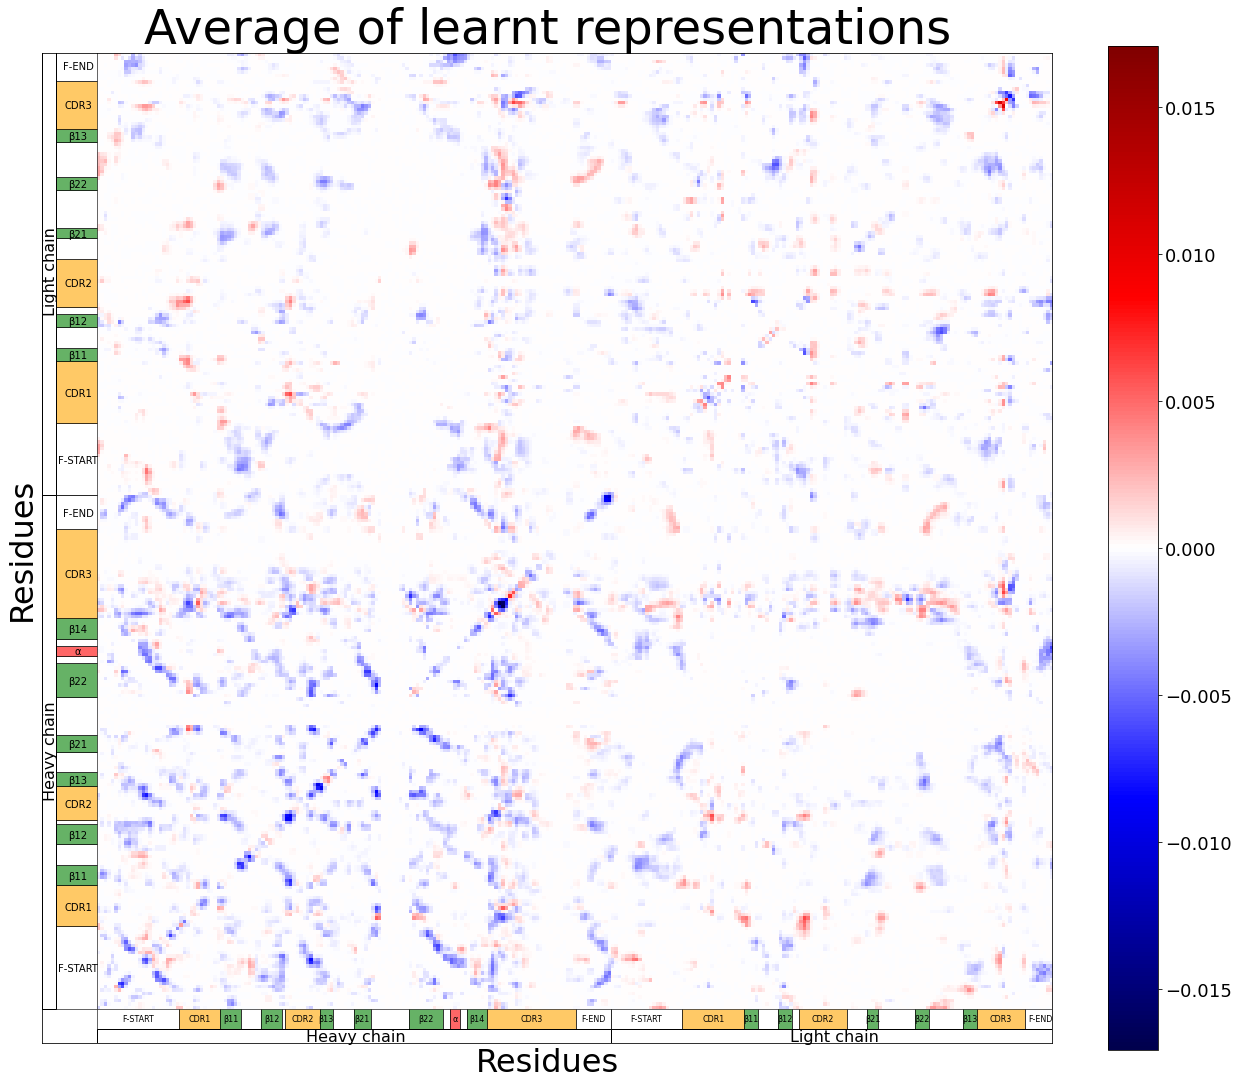

In [5]:
plot_map_with_regions(preprocessed_data, mean_learnt, 'Average of learnt representations')

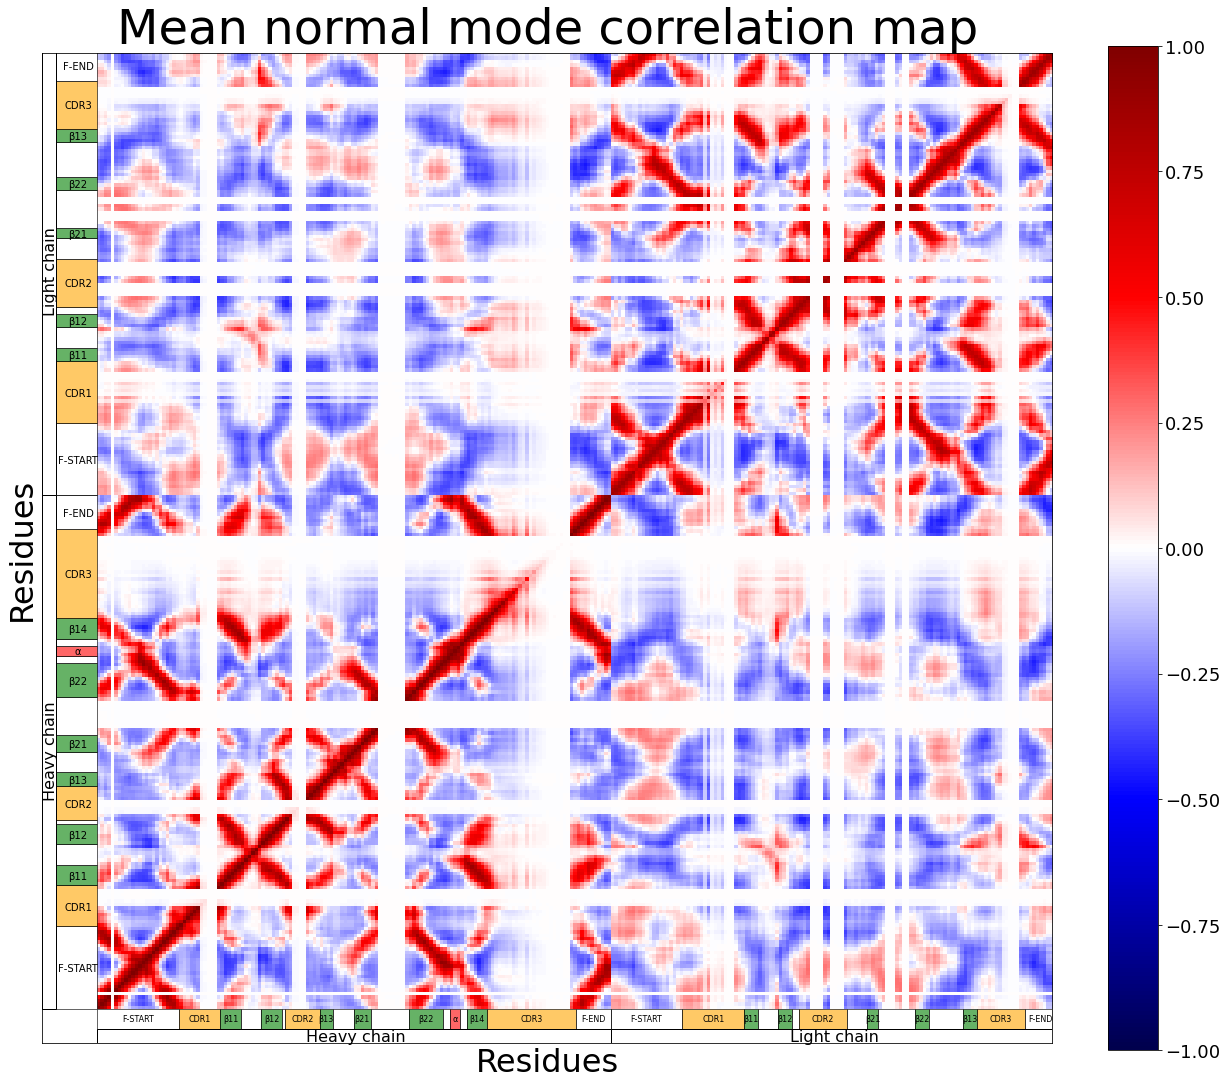

In [6]:
plot_map_with_regions(preprocessed_data, mean_image, 'Mean normal mode correlation map')

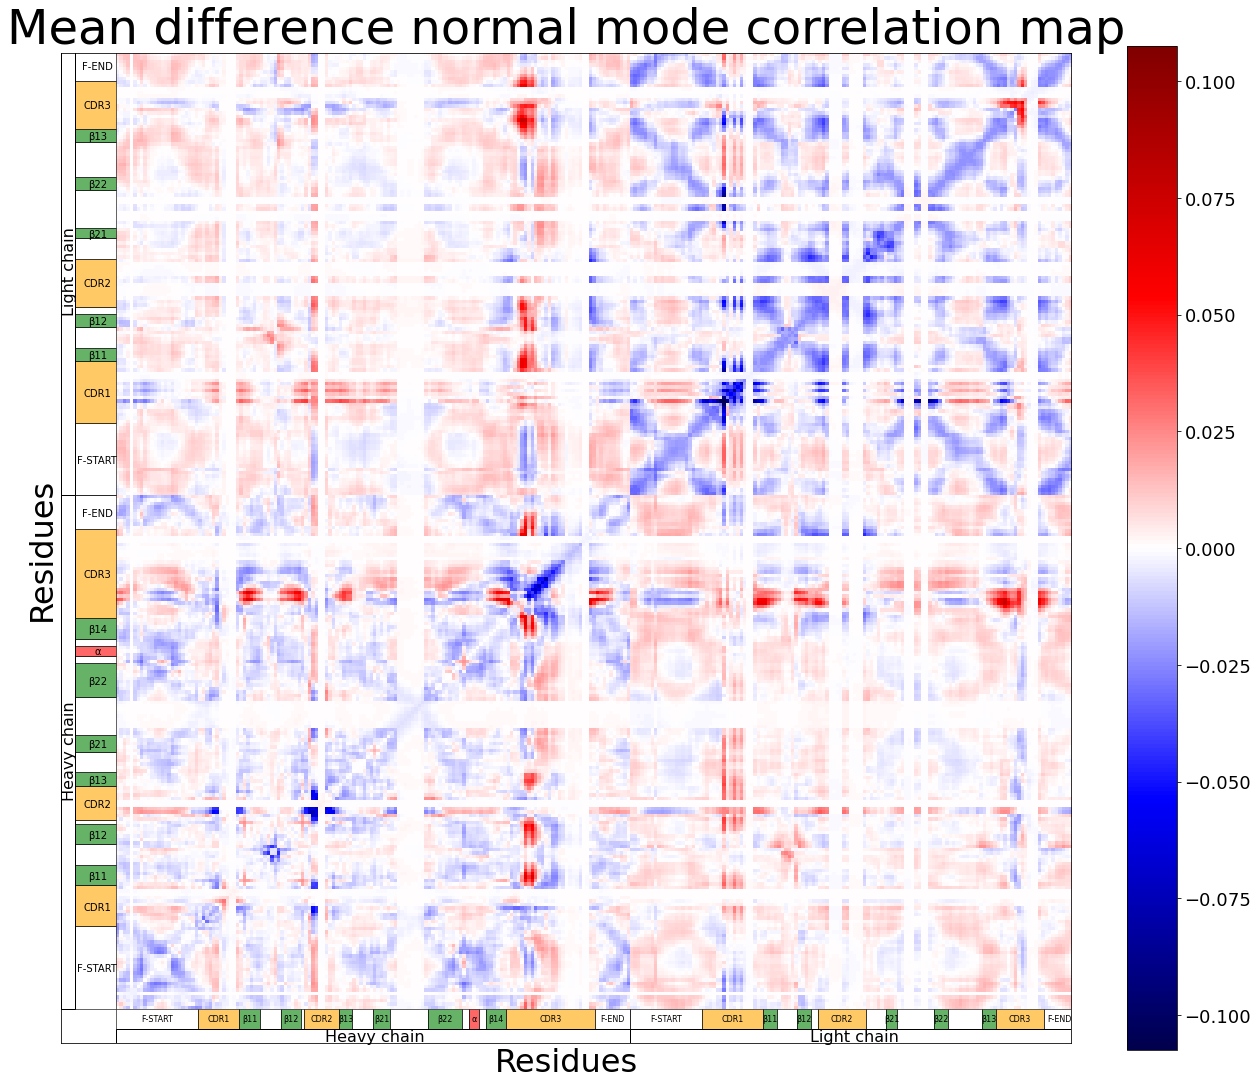

In [7]:
plot_map_with_regions(preprocessed_data, mean_diff_image, 'Mean difference normal mode correlation map')

# Contribution of a test sample

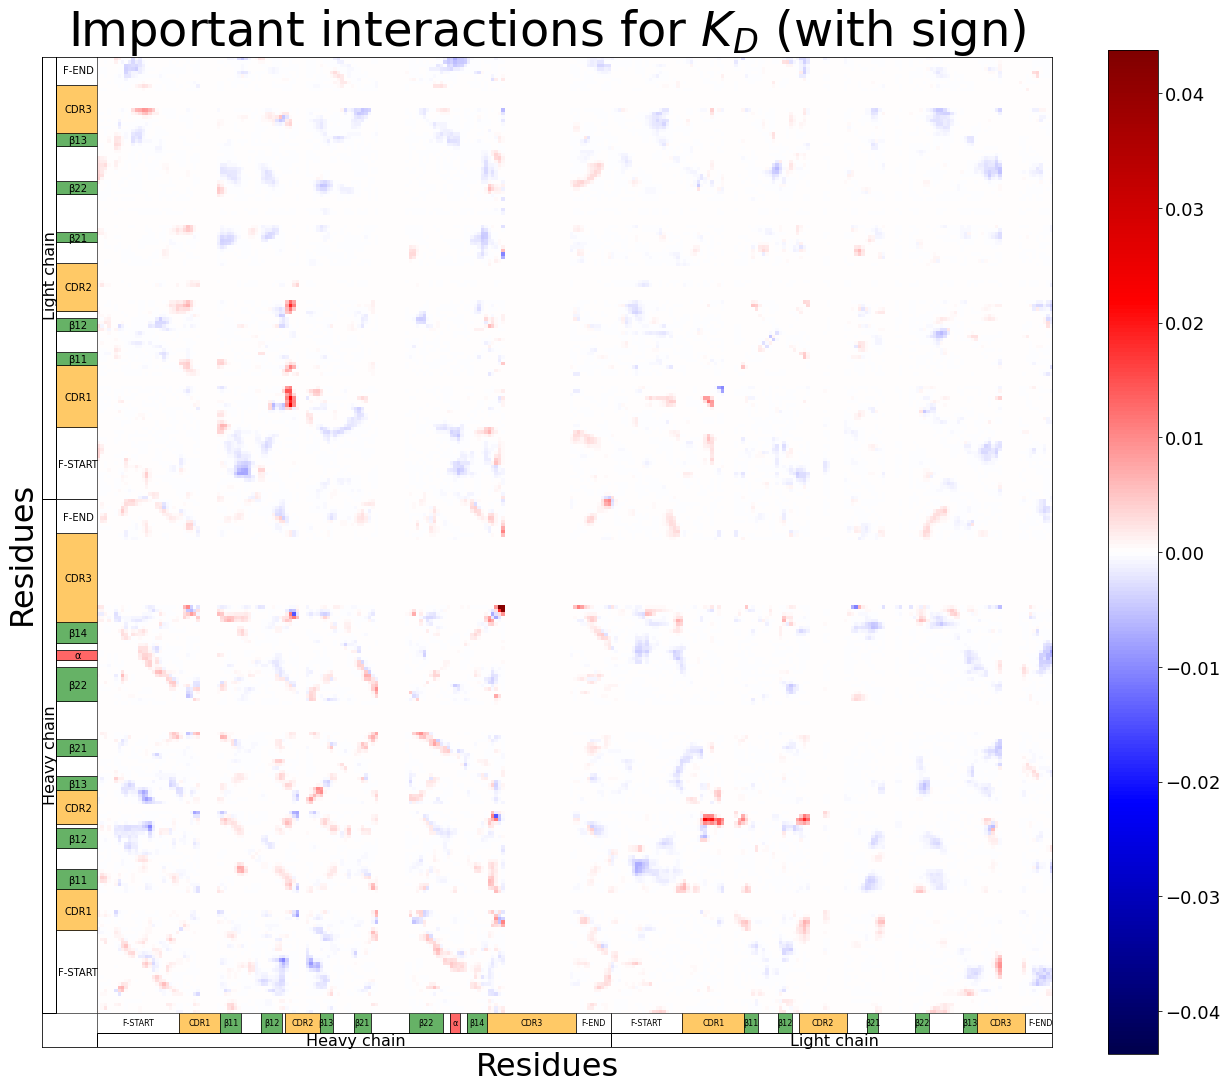

In [8]:
contribution_germline = get_test_contribution(preprocessed_data, model)
plot_map_with_regions(preprocessed_data, contribution_germline, 'Important interactions for $K_D$ (with sign)')

# Obtaining $\epsilon$

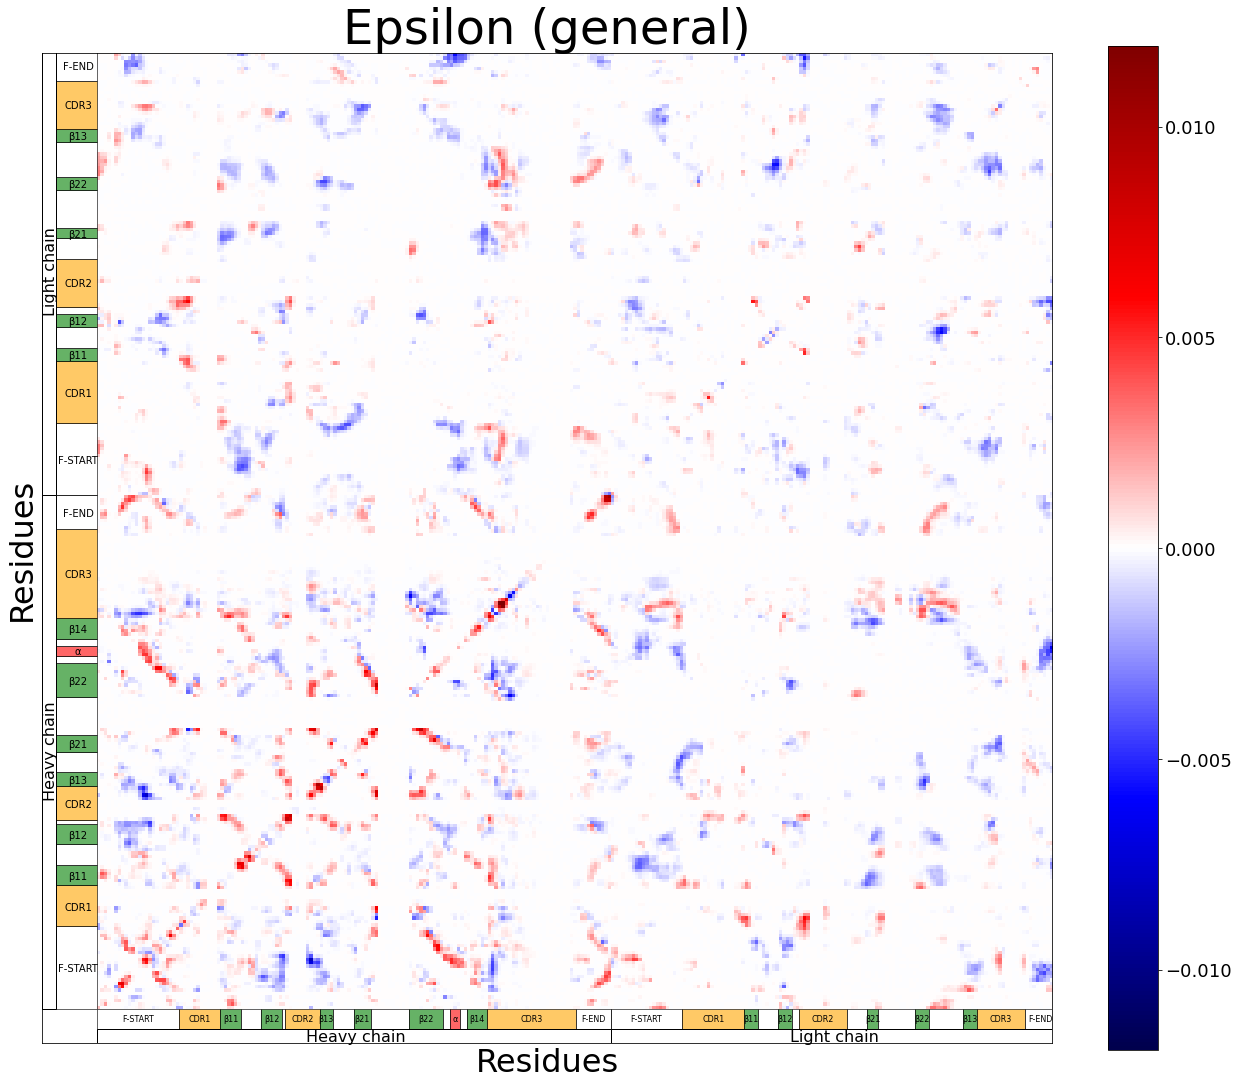

In [9]:
epsilon_gen = get_epsilon(preprocessed_data, model, mode='general')

plot_map_with_regions(preprocessed_data, epsilon_gen, 'Epsilon (general)')

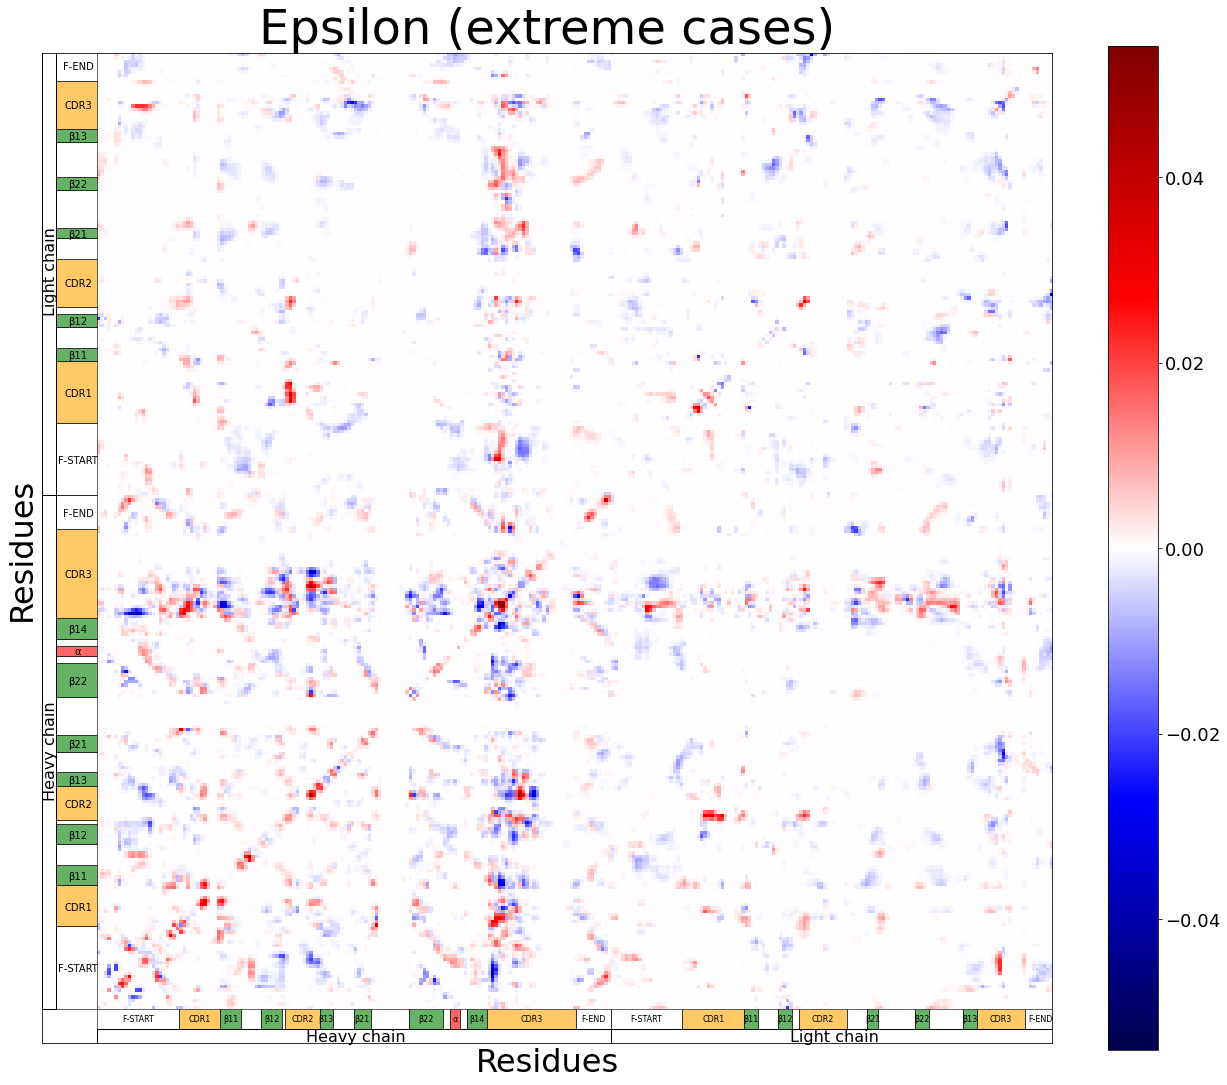

In [10]:
epsilon_ext = get_epsilon(preprocessed_data, model, mode='extreme')

plot_map_with_regions(preprocessed_data, epsilon_ext, 'Epsilon (extreme cases)')

# Change in $K_D$ when adding $\epsilon$

In [11]:
coord, maps, labels = map_residues_to_regions(preprocessed_data, epsilon_gen)

In [24]:
# Here it is possible to tune the weight of each antibody region

# Heavy chain
cdr1_factor_h = 0.1
beta11_factor_h = 0.1 
beta12_factor_h = 0.1 
cdr2_factor_h = 0.1 
beta13_factor_h = 0.1 
beta21_factor_h = 0.1 
beta22_factor_h = 0.1 
alpha_factor_h = 0.1 
beta14_factor_h = 0.1 
cdr3_factor_h = 0.1 

# Light chain
cdr1_factor_l = 0.1 
beta11_factor_l = 0.1 
beta12_factor_l = 0.1 
cdr2_factor_l = 0.1 
beta21_factor_l = 0.1 
beta22_factor_l = 0.1 
beta13_factor_l = 0.1 
cdr3_factor_l = 0.1 

# Expressing weights as vector
weights_h = [cdr1_factor_h, beta11_factor_h, 0.1, beta12_factor_h, 0.1, cdr2_factor_h, beta13_factor_h, 0.1, 
             beta21_factor_h, 0.1, beta22_factor_h, 0.1, alpha_factor_h, 0.1, beta14_factor_h, cdr3_factor_h]
weights_l = [cdr1_factor_l, beta11_factor_l, 0.1, beta12_factor_l, 0.1, cdr2_factor_l, 0.1, beta21_factor_l, 
             0.1, beta22_factor_l, 0.1, beta13_factor_l, cdr3_factor_l]
weights = np.array(weights_h + weights_l)

compute_change_in_kd(preprocessed_data, model, weights, coord, maps)

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.4718878e-07
Thus, Kd is smaller by 1.6002828 %


In [25]:
importance_matrix_signed = np.zeros((len(coord), len(coord)))
for j,_map in enumerate(maps):
    for i in range(len(coord)):
        importance_matrix_signed[i,j] = _map[coord[i],:].sum()

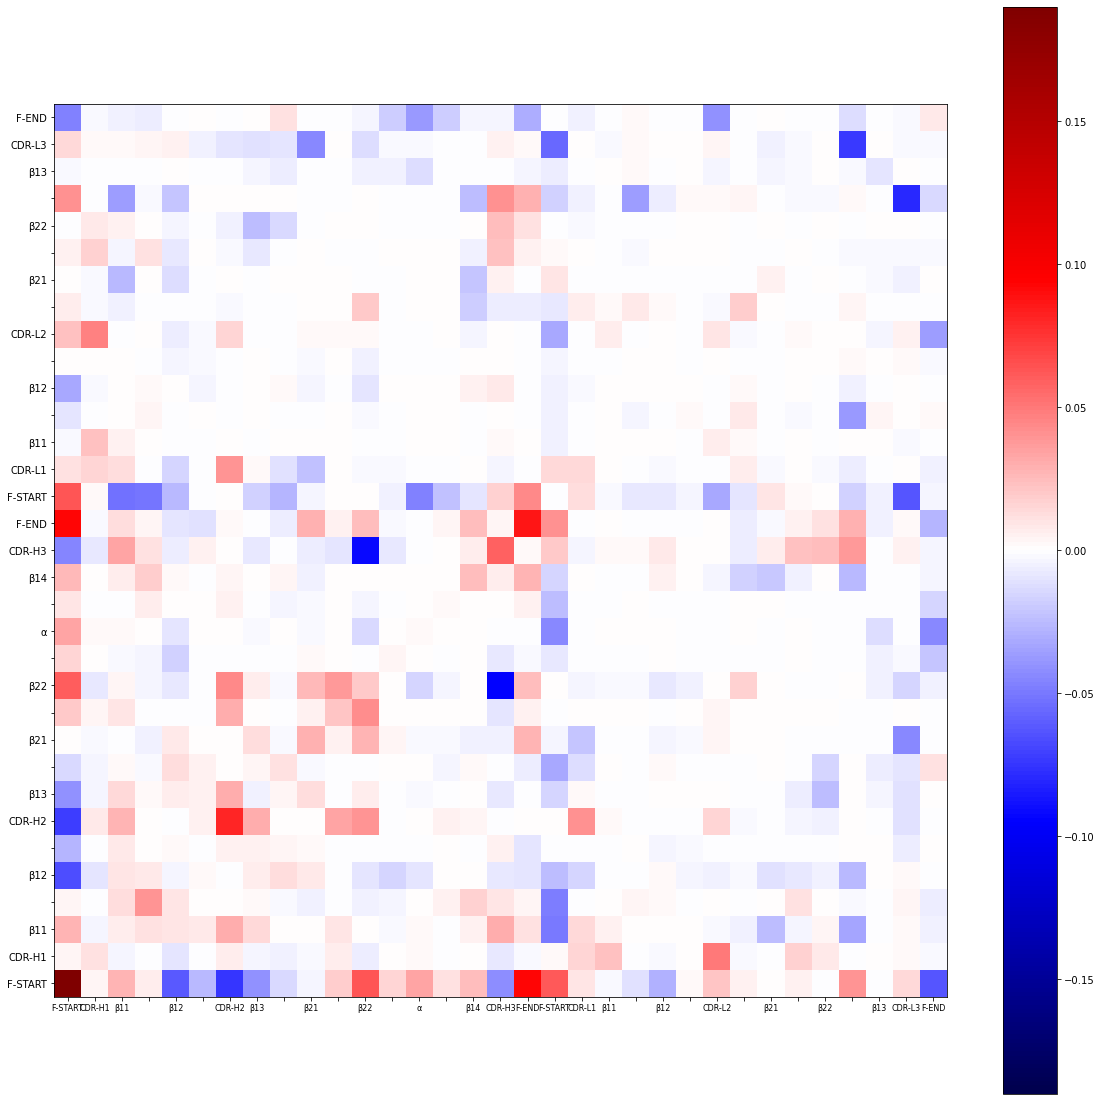

In [26]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(importance_matrix_signed, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

In [27]:
importance_matrix = np.abs(importance_matrix_signed)

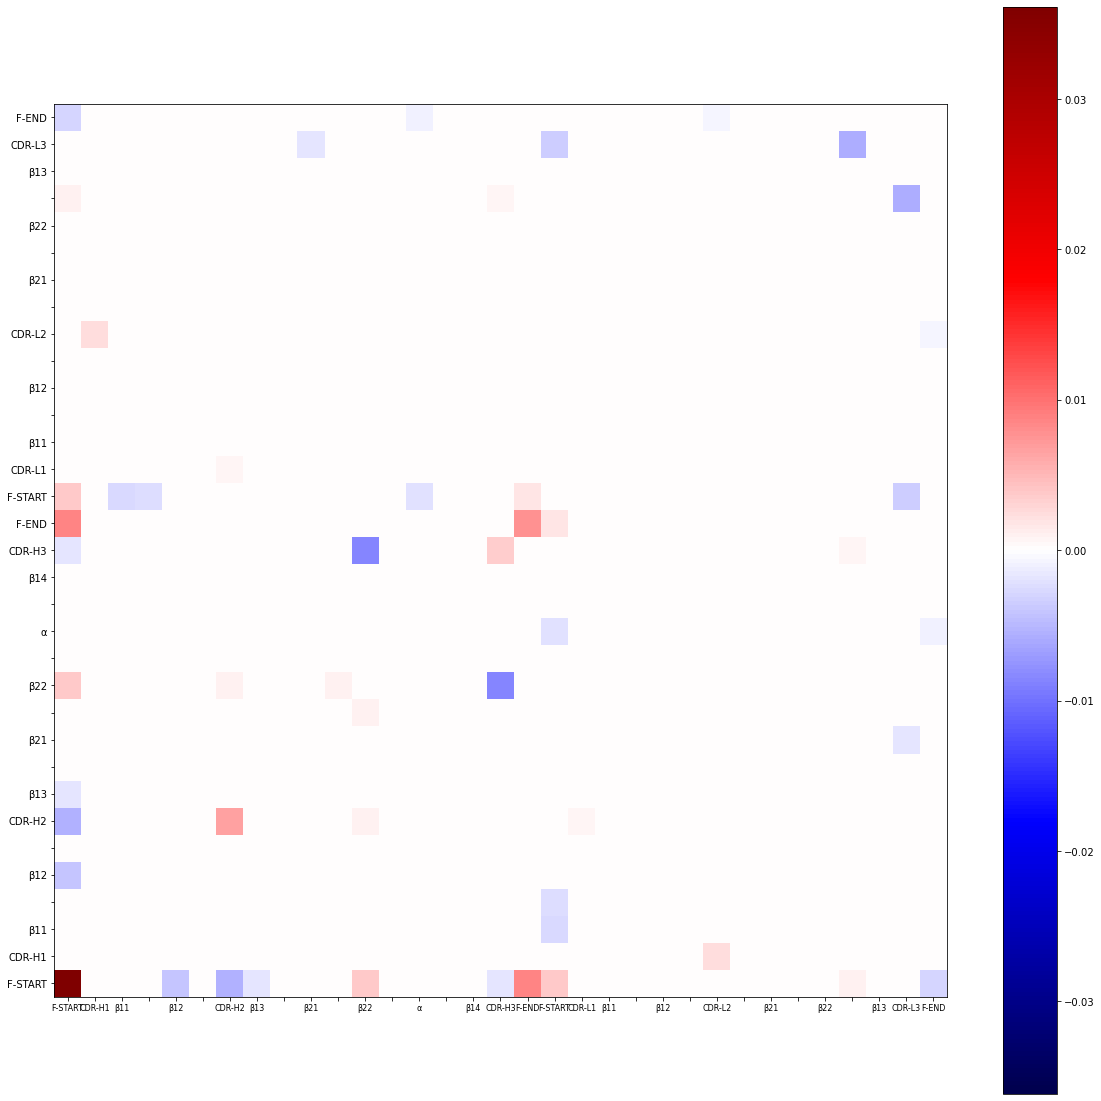

In [29]:
im = np.multiply(np.where(importance_matrix<0.04, 0, importance_matrix), importance_matrix_signed)

fig = plt.figure(figsize=(20, 20))
plt.imshow((im + np.transpose(im))/2, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

## One region at a time

In [30]:
for i in range(len(coord)):
    weights_at_a_time = np.zeros((len(coord)))
    weights_at_a_time[i] = 0.1
    print('---------------------------------------------')
    print(labels[i])
    compute_change_in_kd(preprocessed_data, model, weights_at_a_time, coord, maps)

---------------------------------------------
F-START
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.50512e-07
Thus, Kd is smaller by 0.27739608 %
---------------------------------------------
CDR-H1
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5092655e-07
Thus, Kd is smaller by 0.112370424 %
---------------------------------------------
β11
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5101585e-07
Thus, Kd is smaller by 0.07682191 %
---------------------------------------------

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5109716e-07
Thus, Kd is smaller by 0.044452615 %
---------------------------------------------
β12
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5101858e-07
Thus, Kd is smaller by 0.07573576 %
---------------------------------------------

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.511603e-07
Thus, Kd is smal

# PCA

In [37]:
pca = PCA(2) # 2 principal components

In [38]:
train_x = preprocessed_data.train_x
train_y = preprocessed_data.train_y
n_filters = model.n_filters
each_img_enl = np.zeros((train_x.shape[0], input_shape**2))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
labels = preprocessed_data.labels
clusters = []

for j in range(train_x.shape[0]):
    inter_filter_item = model(torch.from_numpy(train_x[j].reshape(1, 1, input_shape, input_shape).astype(np.float32)))[1].detach().numpy()
    for i in range(n_filters):
        each_img_enl[j] += cv2.resize(np.multiply(inter_filter_item[0,i], model.fc1.weight.data.numpy().reshape(n_filters, size_le**2)[i].reshape(size_le, size_le)), dsize=(input_shape, input_shape)).reshape((input_shape**2))


In [39]:
converted_data = pca.fit_transform(each_img_enl)
for j in range(train_x.shape[0]):
    if np.sum(np.multiply(each_img_enl[j].reshape(input_shape, input_shape), pca.components_[1,:].reshape(input_shape, input_shape))) <= 0:
        clusters.append('Low')
    else:
        clusters.append('High')

In [40]:
each_img_enl.shape

(669, 78961)

In [41]:
converted_data.shape

(669, 2)

In [42]:
cluster_according_to = 'heavy_species'
db = pd.read_csv('../data/sabdab_summary_all.tsv', sep='\t').loc[:,['pdb',cluster_according_to]]

clusters = []
for i in range(len(labels)):
    clusters.append(str(db[db['pdb'] == labels[i]].iloc[0][cluster_according_to]))

In [43]:
'''
cdict = {max(clusters, key=clusters.count): 0,
         max(list(filter(lambda item: item != max(clusters, key=clusters.count), clusters)), key=list(filter(lambda item: item != max(clusters, key=clusters.count), clusters)).count): 1,
         'other': 2}

cdict = {'IGKV1': 0,
         'IGKV2': 1,
         'IGKV3': 2,
         'IGKV4': 3,
         'IGKV5': 4,
         'IGKV6': 5,
         'IGKV7': 6,
         'IGKV8': 7,
         'IGKV9': 8,
         'IGKV10': 9,
         'IGKV14': 10,
         'IGLV1': 11,
         'IGLV2': 12,
         'IGLV6': 13,
         'Other': 14,}

cdict = {'IGHV1': 0,
         'IGHV2': 1,
         'IGHV3': 2,
         'IGHV4': 3,
         'IGHV5': 4,
         'IGHV6': 5,
         'IGHV7': 6,
         'Other': 7,}
'''

cdict = {'homo sapiens': 0,
        'mus musculus': 1,
         'Other': 2}
#cdict = {'Kappa': 0,
#        'Lambda': 1,
#         'Unknown': 2,
#         'None': 3,
#         'Other': 4,}
colours = []
for i in range(len(clusters)):
    if clusters[i] in cdict:
        colours.append(cdict[clusters[i]])
    else:
        colours.append(cdict['Other'])
        clusters[i] = 'Other'

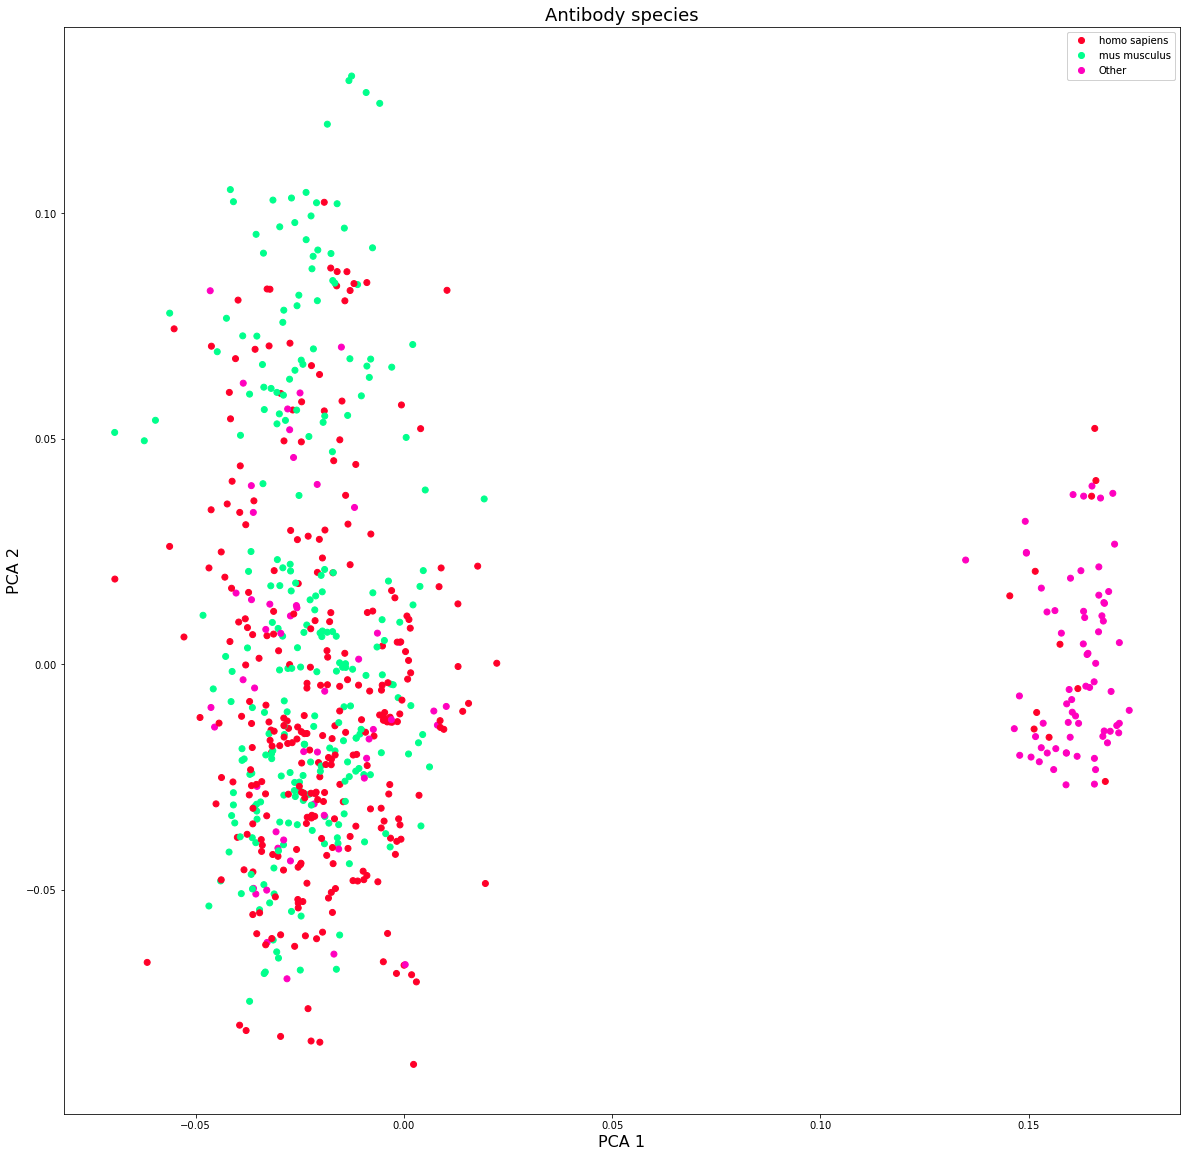

In [44]:
import matplotlib
import matplotlib.patches as mpatches

unique_colours = list(set(colours))
norm = plt.Normalize(np.min(colours), np.max(colours))
cmap = matplotlib.colormaps.get_cmap('gist_rainbow')
legend_patches = [mpatches.Patch(color=cmap(norm(color))) for color in unique_colours]
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.scatter(converted_data[:, 0], converted_data[:, 1], c=colours, cmap=cmap)

#for i, txt in enumerate(range(train_x.shape[0])):
#    ax.annotate(labels[i], (converted_data[i, 0], converted_data[i, 1]), size=10)

handles, _ = im.legend_elements(prop="colors") 
legend1 = ax.legend(handles, cdict.keys(), loc='upper right')
ax.add_artist(legend1)
ax.set_title('Antibody species', size=18)
ax.set_xlabel('PCA 1', size=16)
ax.set_ylabel('PCA 2', size=16)
plt.show()

plt.show()


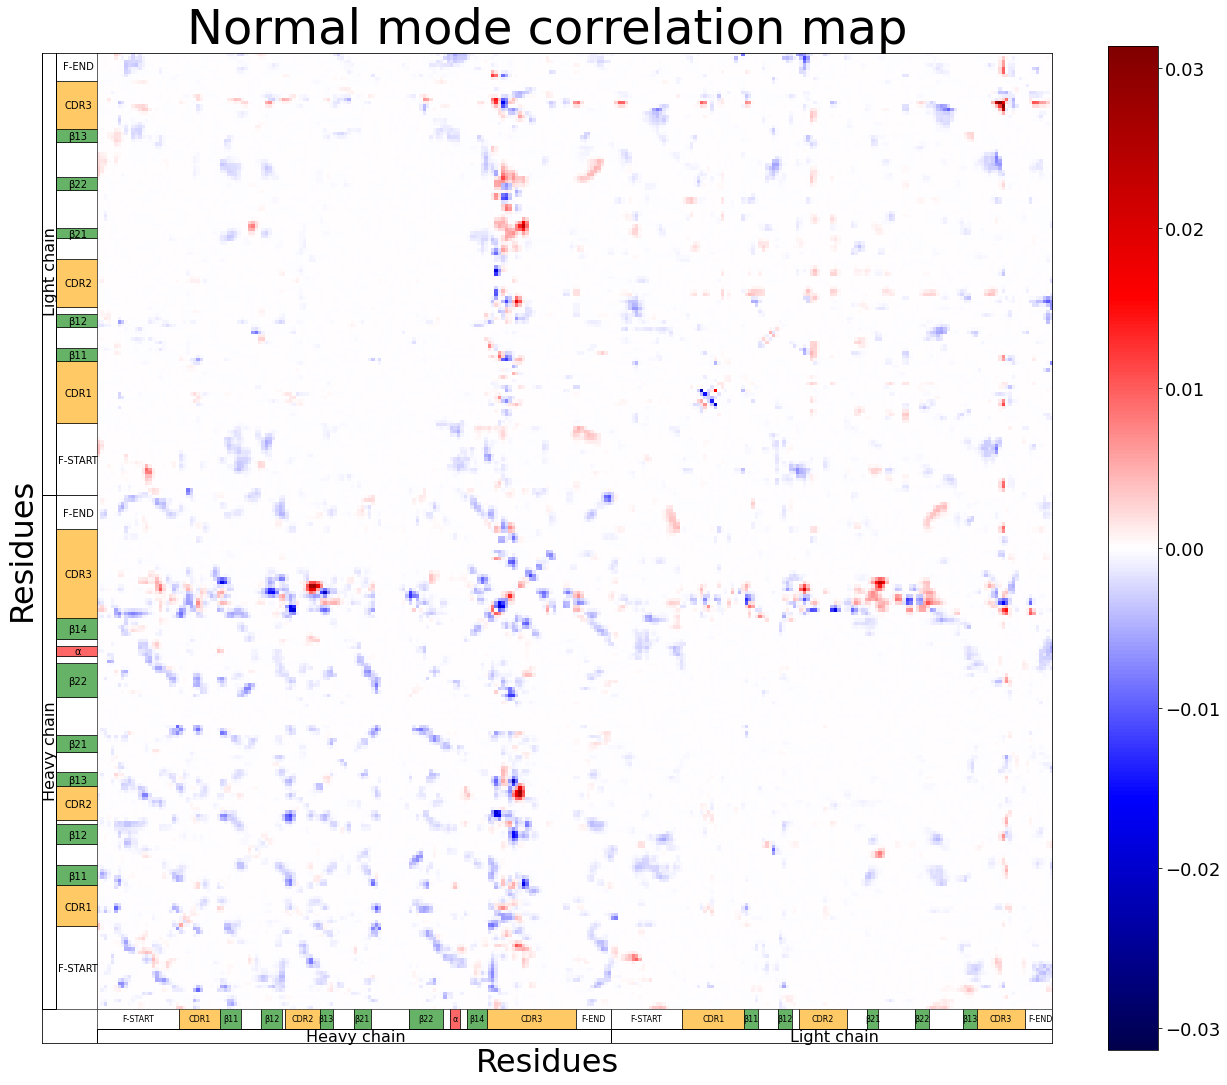

In [45]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('2xtj')].reshape(input_shape, input_shape))

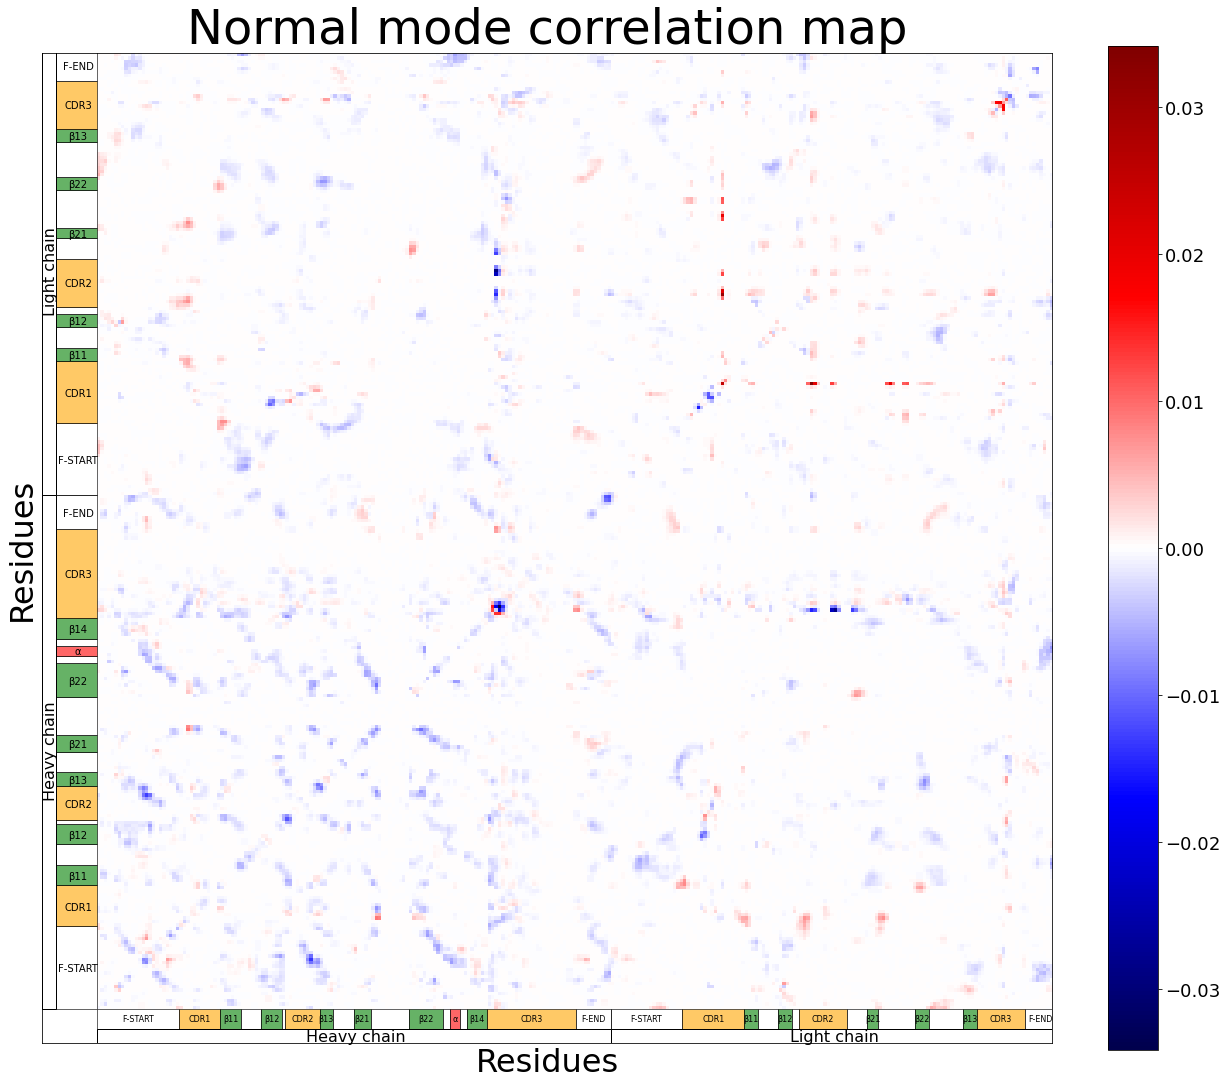

In [46]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('1dl7')].reshape(input_shape, input_shape))

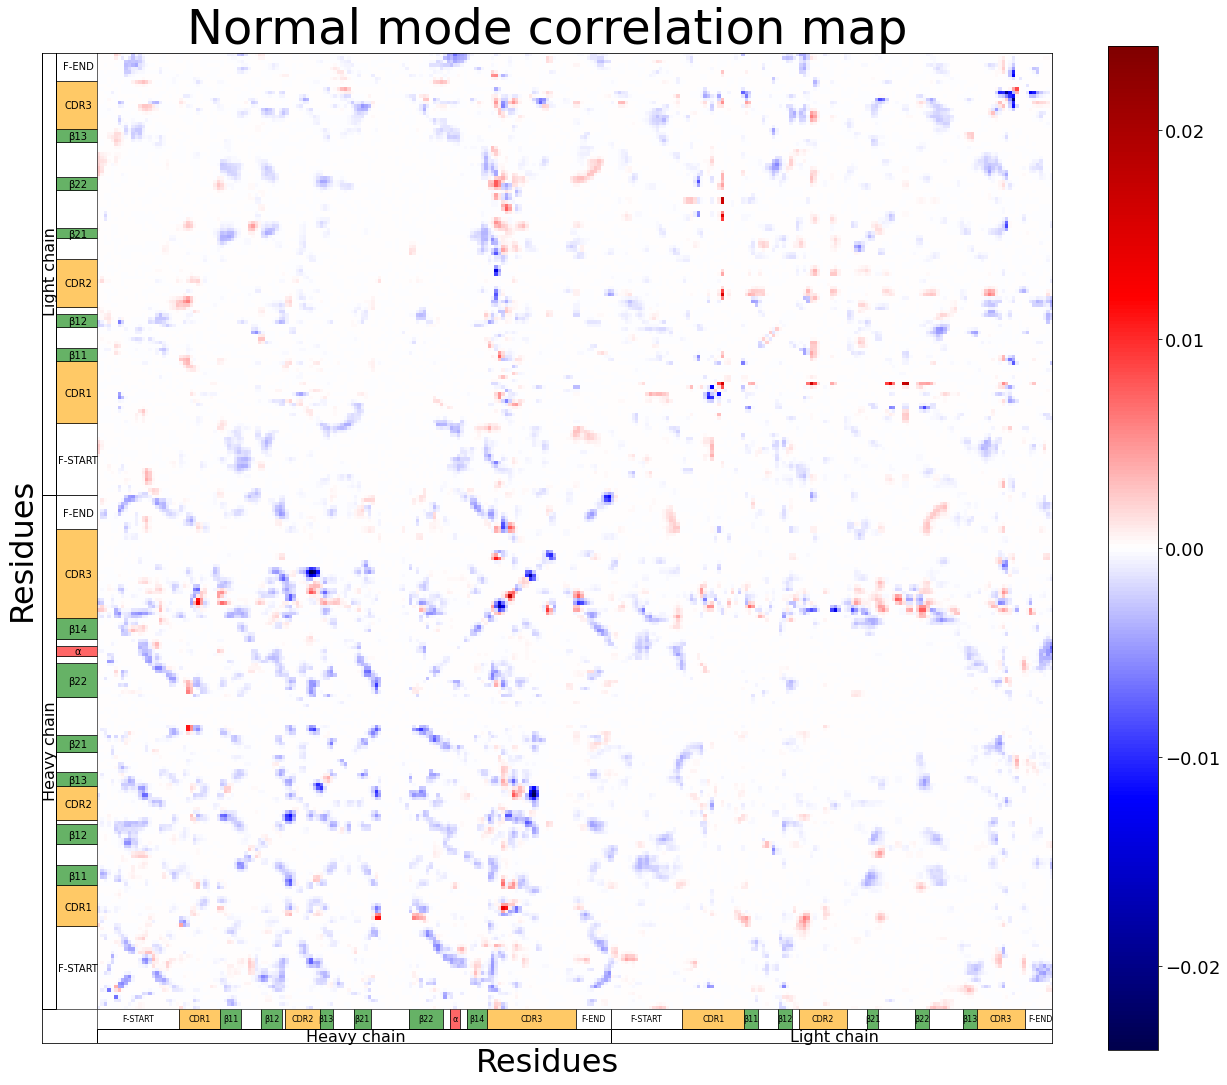

In [47]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('5alb')].reshape(input_shape, input_shape))

In [48]:
pca.explained_variance_ratio_

array([0.19032327, 0.08993401])

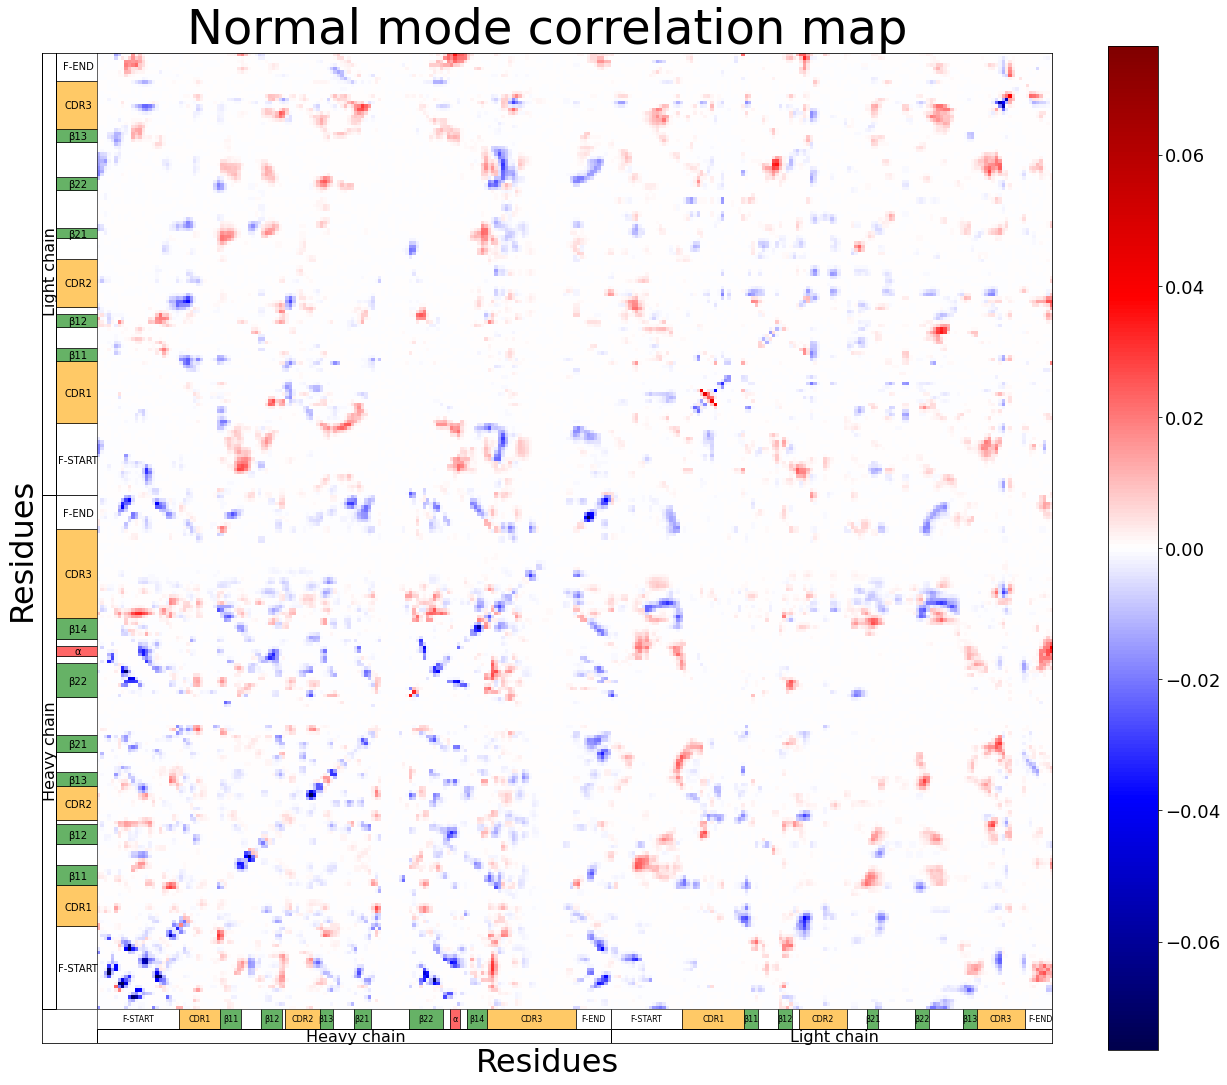

In [53]:
plot_map_with_regions(preprocessed_data, pca.components_[0,:].reshape(input_shape, input_shape))

# UMAP

In [10]:
reducer = umap.UMAP(random_state=32, min_dist=0.1, n_neighbors=90) # result for general
#reducer = umap.UMAP(random_state=32, min_dist=0.15, n_neighbors=16) # result for heavy

In [11]:
reducer

UMAP(n_neighbors=90, random_state=32)

In [12]:
train_x = preprocessed_data.train_x
train_y = preprocessed_data.train_y
n_filters = model.n_filters
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
heavy_length = len(preprocessed_data.max_res_list_h)
each_img_enl = np.zeros((train_x.shape[0], input_shape**2))
#each_img_enl = np.zeros((train_x.shape[0], heavy_length**2))
labels = preprocessed_data.labels
clusters = []

for j in range(train_x.shape[0]):
    inter_filter_item = model(torch.from_numpy(train_x[j].reshape(1, 1, input_shape, input_shape).astype(np.float32)))[1].detach().numpy()
    for i in range(n_filters):
        each_img_enl[j] += cv2.resize(np.multiply(inter_filter_item[0,i], model.fc1.weight.data.numpy().reshape(n_filters, size_le**2)[i].reshape(size_le, size_le)), dsize=(input_shape, input_shape)).reshape((input_shape**2))
        #each_img_enl[j] += cv2.resize(np.multiply(inter_filter_item[0,i], model.fc1.weight.data.numpy().reshape(n_filters, size_le**2)[i].reshape(size_le, size_le)), dsize=(input_shape, input_shape))[:heavy_length, :heavy_length].reshape((heavy_length**2))
    if train_y[j] <= -9:
        clusters.append('high')
    elif train_y[j] >= -9 and train_y[j] <= -7:
        clusters.append('medium')
    else:
        clusters.append('low')     

In [13]:
scaled_each_img = StandardScaler().fit_transform(each_img_enl)

In [14]:
embedding = reducer.fit_transform(scaled_each_img)
embedding.shape

(669, 2)

In [22]:
cluster_according_to = 'heavy_species'
db = pd.read_csv('../data/sabdab_summary_all.tsv', sep='\t').loc[:,['pdb',cluster_according_to]]

clusters = []
for i in range(len(labels)):
    clusters.append(str(db[db['pdb'] == labels[i]].iloc[0][cluster_according_to]))

In [19]:
clusters = []
for j in range(len(labels)):
    if charge[j] == 'unknown':
        clusters.append('unknown')
    elif float(charge[j]) > 0.4:
        clusters.append('high')
    elif float(charge[j]) <= 0.4 and float(charge[j]) >= 0.1:
        clusters.append('medium')
    else:
        clusters.append('low')    


In [23]:
'''
cdict = {max(clusters, key=clusters.count): 0,
         max(list(filter(lambda item: item != max(clusters, key=clusters.count), clusters)), key=list(filter(lambda item: item != max(clusters, key=clusters.count), clusters)).count): 1,
         'other': 2}

cdict = {'IGKV1': 0,
         'IGKV2': 1,
         'IGKV3': 2,
         'IGKV4': 3,
         'IGKV5': 4,
         'IGKV6': 5,
         'IGKV7': 6,
         'IGKV8': 7,
         'IGKV9': 8,
         'IGKV10': 9,
         'IGKV14': 10,
         'IGLV1': 11,
         'IGLV2': 12,
         'IGLV6': 13,
         'Other': 14,}
'''
cdict = {'IGHV1': 0,
         'IGHV2': 1,
         'IGHV3': 2,
         'IGHV4': 3,
         'IGHV5': 4,
         'IGHV6': 5,
         'IGHV7': 6,
         'Other': 7,}

cdict = {'homo sapiens': 0,
        'mus musculus': 1,
         'Other': 2}


#cdict = {'Kappa': 0,
#        'Lambda': 1,
#         'unknown': 2,
#         'NA': 3,
#         'Other': 4,}

#cdict = {'high': 0,
#        'medium': 1,
#         'low': 2,
#         'unknown': 3,
#         'Other': 4}
colours = []
for i in range(len(clusters)):
    if clusters[i] in cdict:
        colours.append(cdict[clusters[i]])
    else:
        colours.append(cdict['Other'])
        clusters[i] = 'Other'

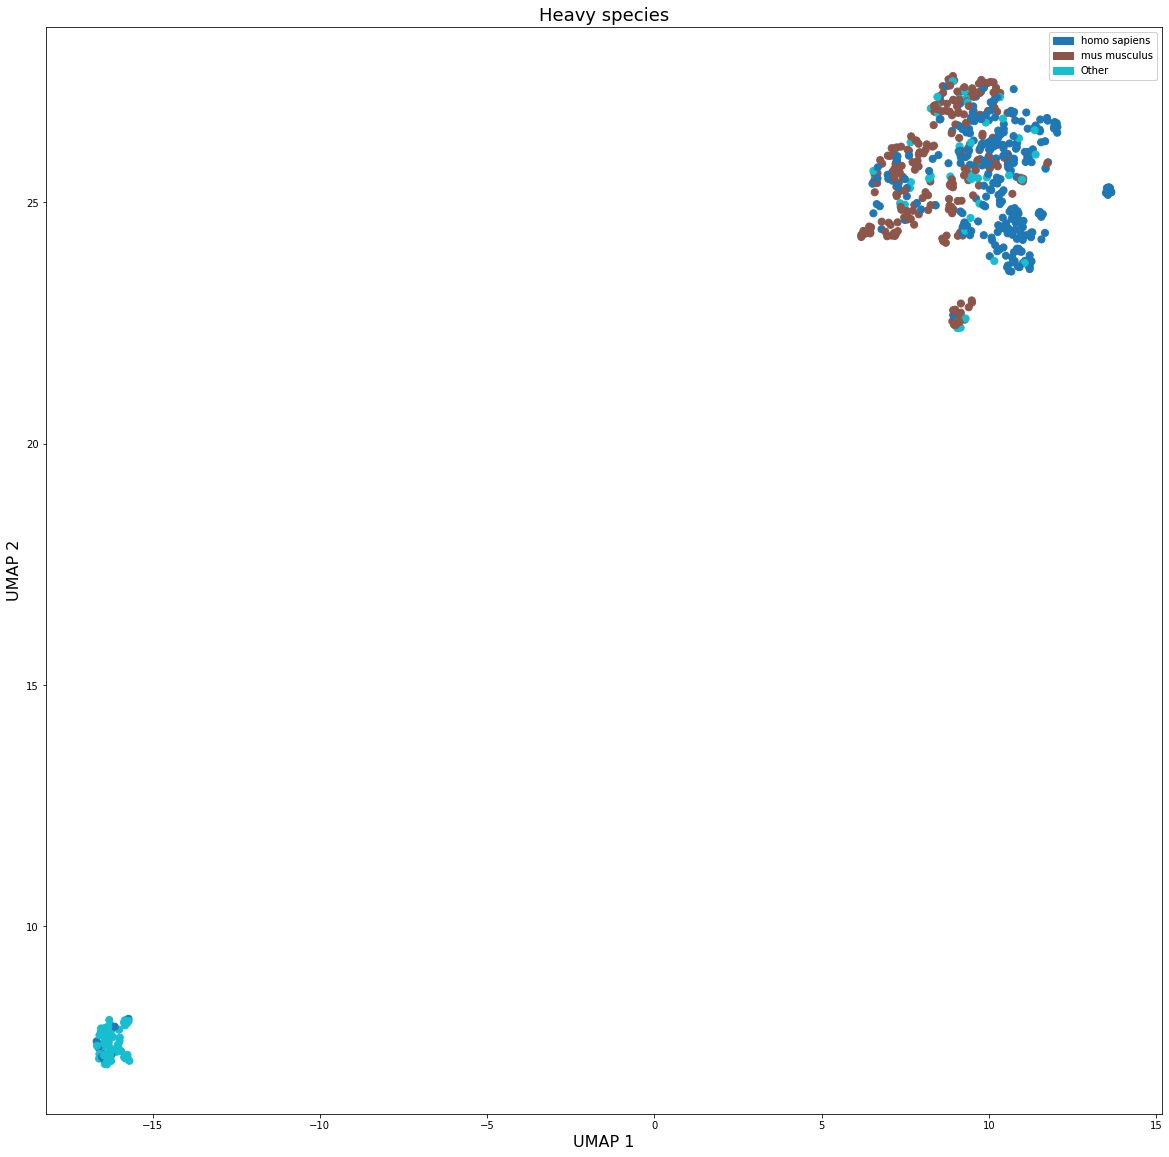

In [24]:
import matplotlib.patches as mpatches
import matplotlib

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

unique_colours = list(set(colours))
norm = plt.Normalize(np.min(colours), np.max(colours))
cmap = matplotlib.colormaps.get_cmap('tab10')
legend_patches = [mpatches.Patch(color=cmap(norm(color))) for color in unique_colours]
im = ax.scatter(embedding[:, 0], embedding[:, 1] , s=50, c=colours, cmap=cmap)

#for i, txt in enumerate(labels):
#    ax.annotate(labels[i], (embedding[i, 0], embedding[i, 1]), size=8)

# Inverse of the chi-squared CDF
conf_level = 0.75
inv_chi2 = chi2.ppf(conf_level, df=2)
ellipses = []  # Store ellipse information

for label in unique_colours:
    label_points = embedding[np.array(colours) == label]  # Subset of UMAP points for a specific label
    n_points = len(label_points)
    
    # Calculate the centroid using all the points of a class
    center = np.mean(label_points, axis=0)
    covariance = np.cov(label_points.T)
    # Calculate the distance of each point
    dist = np.sum(np.square(label_points - center), axis=1)
    
    # Sort the points based on the distance
    sorted_indices = np.argsort(dist)
    
    # Calculate the number of points to include within the ellipse
    n_inside = int(np.ceil(n_points * conf_level))
    
    # Select the points that fall within the ellipse
    inside_points = label_points[sorted_indices[:n_inside]]
    
    # Recalculate the mean and covariance using only the inside points
    center = np.mean(inside_points, axis=0)
    covariance = np.cov(inside_points.T)
    
    # Calculate the eigenvalues and eigenvectors of the covariance matrix again
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Calculate the scaling factor for the ellipse based on the eigenvalues again
    scale_factor = np.sqrt(inv_chi2)
    
    # Calculate the radius of the ellipse based on the eigenvalues and the scaling factor
    radius = np.sqrt(eigenvalues) * scale_factor
    
    ellipse = patches.Ellipse(xy=center, width=2 * radius[0], height=2 * radius[1],
                              angle=angle, fill=False, linewidth=3, alpha=0.7, color=cmap(norm(label)))
    ellipses.append(ellipse)

legend1 = ax.legend(legend_patches, cdict.keys(), loc='upper right')
ax.add_artist(legend1)

#for i, ellipse in enumerate(ellipses):
#    if list(cdict.keys())[i] not in ['unknown', 'Other']:
#        ax.add_patch(ellipse)
ax.set_title('Heavy species', size=18)
ax.set_xlabel('UMAP 1', size=16)
ax.set_ylabel('UMAP 2', size=16)
plt.show()

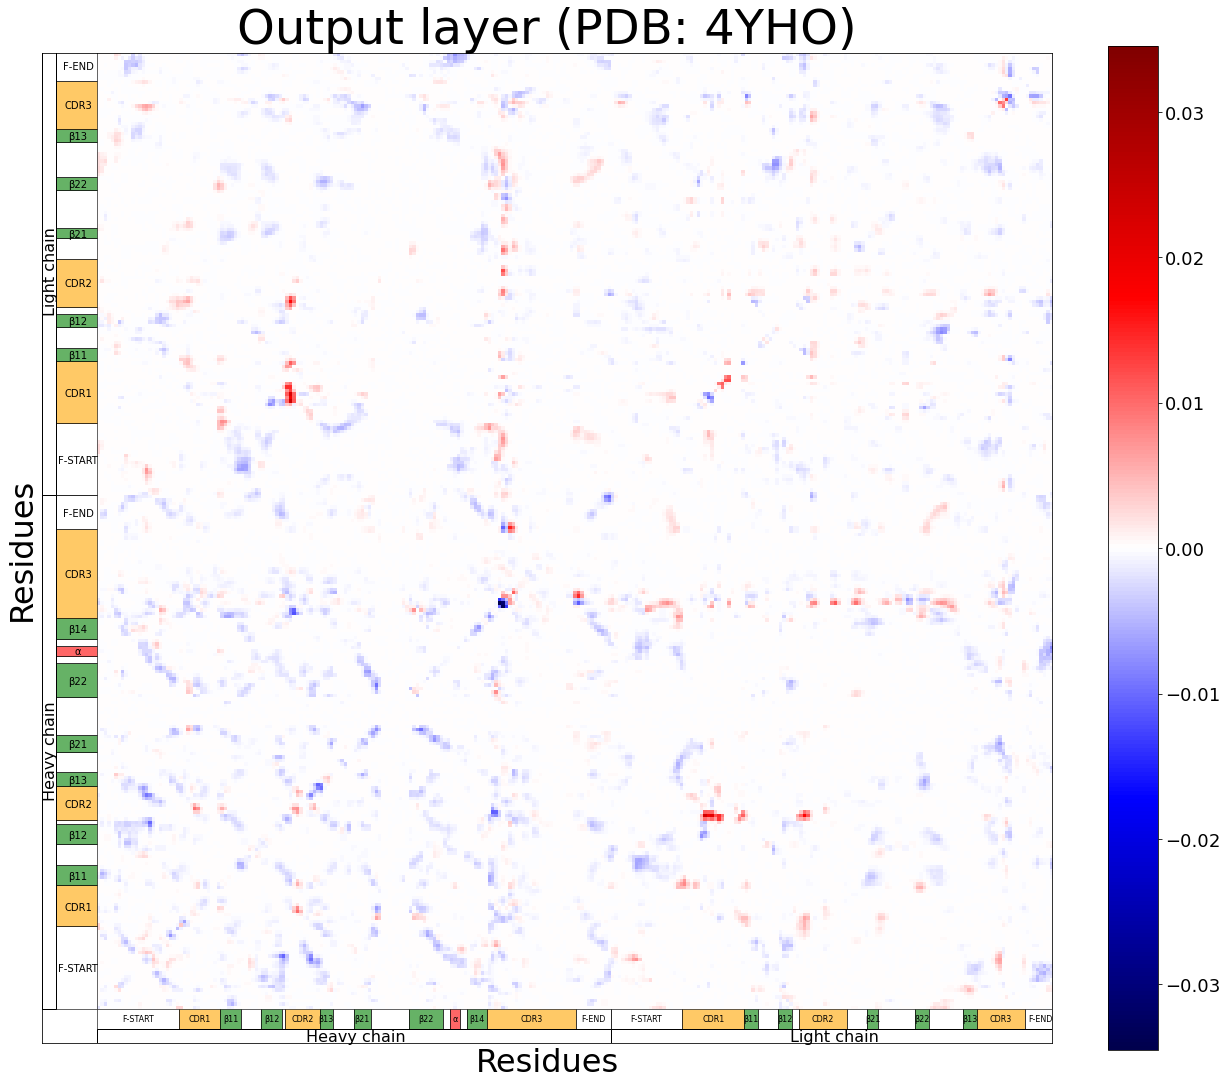

In [35]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('1kel')].reshape(input_shape, input_shape), 'Output layer (PDB: 4YHO)')

In [6]:
import requests
from bs4 import BeautifulSoup

aromatic_residues = ['W', 'Y', 'F', 'H']
aliphatic_hydrophobic_residues = ['A', 'V', 'L', 'I', 'P', 'M', 'C']
charged_residues = ['D', 'E', 'K', 'R']
polar_residues = ['N', 'Q', 'S', 'T']
aromaticity = []
hydrophobicity = []
charge = []
polarity = []

def extract_paratope_epitope(pdb_code, region='Paratope'):
    url = f'https://www.imgt.org/3Dstructure-DB/cgi/details.cgi?pdbcode={pdb_code}&Part=Epitope'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table_headers = soup.find_all('td', class_='titre_title')
    table_rows = soup.find_all('tr')
    residue_row = None
    for row in table_rows:
        if row.find('td', class_='titre_title') and region.lower() in row.text.lower():
            type_row = row.find_next_sibling('tr')
            residue_row = type_row.find_next_sibling('tr')
            res_chain_row = residue_row.find_next_sibling('tr')
            break

    if residue_row:
        type_text = type_row.find('td', class_='data_r').text.strip()
        residues_text = residue_row.find('td', class_='data_r').text.strip().replace('IMGT Residue@Position cards', '')
        res_chain_text = res_chain_row.find('td', class_='data_r').text.strip()
        return type_text, residues_text, res_chain_text
    else:
        return ''
    
for pdb_code in labels:
    print(pdb_code)
    paratope = extract_paratope_epitope(pdb_code, 'Paratope')
    if paratope == '' or paratope[1] == '':
        aromaticity.append('unknown')
        hydrophobicity.append('unknown')
        charge.append('unknown')
        polarity.append('unknown')
    else:
        epitope = extract_paratope_epitope(pdb_code, 'Epitope')
        paratope_list = paratope[1].split()
        aromaticity.append(len([residue for residue in paratope_list if residue in aromatic_residues])/len(paratope_list))
        hydrophobicity.append(len([residue for residue in paratope_list if residue in aliphatic_hydrophobic_residues])/len(paratope_list))
        charge.append(len([residue for residue in paratope_list if residue in charged_residues])/len(paratope_list))
        polarity.append(len([residue for residue in paratope_list if residue in polar_residues])/len(paratope_list))

1a4k
1aj7
1axs
1bj1
1bvk
1c12
1c5c
1ct8
1cz8
1d6v
1dbb
1dl7
1dqj
1dzb
1e6j
1eo8
1etz
1f4x
1f4y
1f90
1fe8
1fl3
1fl6
1flr
1fsk
1g6v
1gaf
1hez
1hh6
1hh9
1i7z
1i8i
1i8k
1i8m
1igj
1ind
1iqd
1jgl
1jps
1jrh
1kel
1kxq
1kxt
1kxv
1m7d
1m7i
1mfa
1mfd
1mh5
1mjj
1mlc
1mpa
1n64
1n7m
1nby
1nbz
1nca
1ngw
1nl0
1nma
1nsn
1oau
1oay
1ob1
1op9
1p2c
1p4b
1pz5
1q72
1qfu
1ri8
1s3k
1sm3
1sy6
1tet
1tzh
1tzi
1uwx
1uz8
1vfb
1w72
1wej
1y0l
1yei
1yej
1yy9
1yyl
1yym
1za3
1zea
1zmy
1zv5
1zvy
2a6i
2a6k
2aep
2aeq
2b2x
2bdn
2bjm
2c1p
2cgr
2cmr
2dd8
2e27
2eh8
2fjg
2fjh
2fl5
2fr4
2fx7
2fx8
2fx9
2g2r
2h9g
2hfg
2hkf
2hrp
2i5y
2i60
2iff
2j4w
2j5l
2j6e
2jb5
2jb6
2jel
2jix
2mpa
2ntf
2nxy
2nxz
2ny0
2ny1
2ny2
2ny3
2ny4
2ny5
2ny6
2ny7
2nyy
2nz9
2oqj
2or9
2p42
2p43
2p44
2p45
2p46
2p47
2p48
2p49
2p4a
2pcp
2qhr
2qr0
2r0k
2r0l
2r0z
2r1w
2r1x
2r1y
2r23
2r2b
2r56
2r8s
2uzi
2vir
2vis
2vwe
2vxq
2vxs
2vxt
2vyr
2w9e
2wub
2wuc
2x89
2xqb
2xra
2xtj
2xzc
2xzq
2y06
2y07
2y36
2y6s
2ybr
2yk1
2ypv
2z92
2zpk
3a67
3a6b
3a6c
3b2u
3b2v
3bdy
3be1
3bgf
